# Computational Neuroscience - Assignment 1:

## Malaik Kabir (24100156)

In this assignment I have used the following models to simulate a neuron:

1) The leaky Integrate and Fire Model <br><br>
2) The Hodgkin - Huxley Model

## 1) The Leaky Integrate and Fire Model:

The leaky integrate and fire model is a computationally inexpensive model that simulates a neuron as a circuit with a capacitor and a resistor. The resistor serves as a sort of "Leak" channel, energy is dissipated out of the neuron through this leak channel. The capacitor part of the circuit simulates the Nernst Potential across the membrane: charge distributed on the two plates of the capacitor behaves in a similar manner to the charge distributed across the membrane. The differential equation for the sub-threshold behaviour of the Leaky Integrate Model is written as:

$$C\frac{dV}{dt} = - g_L(V-V_L) + I$$

Where $g_L$ is the conductance of the leaky resistor (i.e $\frac{1}{R_L})$,$V_L$ is the voltage acros the leaky resistor, $I$ is the current injected, $V$ is the total voltage across the neuron membrane and $C$ is its capacitance.

Since the LIF model is supposed to model a neuron, it also needs to take into account its spiking behaviour. However, in the case of this model, the behaviour is inserted in a very ad-hoc fashion. That is, the spiking behaviour is not built into the differential equations, but instead is added as an afterthought, roughly as follows:

$$\text{if }V> V_{th} : V = V_{reset} $$

Which basically means that if the voltage exceeds some pre-determined threshold value $V_{th}$ it should be reset to some other value $V_{reset}$ generally a lot smaller than the threshold voltage. This simulates the spiking behaviour.

## Coding up the Leaky Integrate and Fire model:

In order to model the subthreshold behaviour numerically, we solve the differential equation using the Euler method. The Euler method splits the real line (in this case the time axis) into a discrete set of intervals ($\Delta t$). Starting from the first of these intervals, it then "estimates" the function value in the next interval using the gradient of the function computed through the scheme given in the differential equation.

For example in order to predict $V_{n+1}$ from $V_{n}$ we use:

$$\Delta V = \frac{- g_L(V-V_L) + I}{C}\Delta t$$

So that we can say:

$$V_{n+1} = V_{n} + \Delta V$$

Beyond the threshold voltage $V_{th}$, "if statements" are implemented to change the voltage to the reset value.

Before coding up the equation, we first bring it into a more suitable form: one that explicitly shows the time constant $\tau$ of the equation. Such a time constant explicitly dictates how long it takes for the voltage to change appreciably. To do so, we divide the equation by $g_L$ throughout:

$$\frac{C}{g_L}\frac{dV}{dt} = -(V-V_L) + \frac{I}{g_L}$$

Where we now define $\frac{C}{g_L} = \tau$ and rearrange the equation to get:

$$\frac{dV}{dt} = \bigg(-(V-V_L) + \frac{I}{g_L}\bigg)\cdot\frac{1}{\tau}$$

## Keeping all of the Parameters in one place:

We first run a cell that generates a dictionary with all of our parameters in one place. This reduces the hassle of trying to figure out where to change a particular value in order to run the simulation for that value:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def InitializeParameters():
    
    #Defines a dictionary called parameters
    parameters = {}
    
    #The threshold voltage
    parameters['Vthreshold'] = -55.
    
    #The reset voltage
    parameters['Vreset'] = -75.
    
    #The initial voltage
    parameters['Vinitial'] = -65.
    
    #The voltage across the leak resistor
    parameters['Vleak'] = -75.
    
    #The time constant Tau
    parameters['Tau'] = 10.
    
    #The conductance of the leak resistor: g_L
    parameters['Conductance'] = 10.
    
    #Refractory period after a spike
    parameters['Refractory'] = 2.
    
    #Duration over which the simulation runs
    parameters['Duration'] = 400.
    
    #Time step dt between the intervals
    parameters['Timestep'] = 0.1
    
    #All of the time values stored in a numpy array
    parameters['Timegrid'] = np.arange(0, parameters['Duration'], parameters['Timestep'])
    
    #Constant current applied
    parameters['Current'] = 250
    
    return parameters

With the parameter dictionary defined we now turn towards actually defining a function that runs the Leaky Integrate and Fire model.

## Running the Leaky Integrate and Fire Model with a constant input Current:

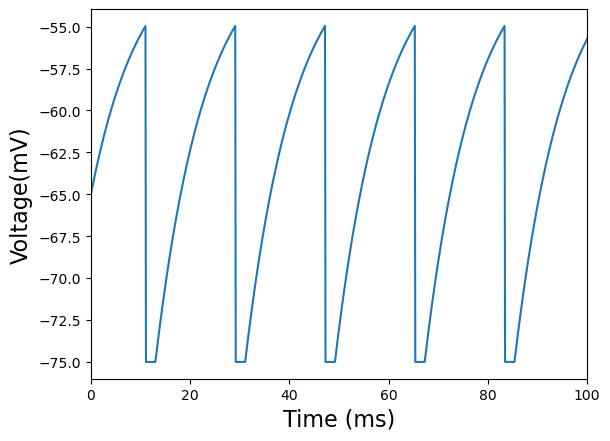

In [2]:
#The following function is used to calculate Delta V when updating the Voltage in the function LeakyIntegrate

def DeltaCalculator(V,I,parameters):
    Vth = parameters['Vthreshold']
    VL  = parameters['Vleak']
    Tau = parameters['Tau']
    dt  = parameters['Timestep']
    gL  = parameters['Conductance']
    
    DeltaV = (-(V - VL) + I/gL) * dt/Tau
    
    return DeltaV

def LeakyIntegrate(parameters, currenttype = 'constant', freq = 1 , sig = 1, seed = 3453):
    I   = parameters['Current']
    Vth = parameters['Vthreshold']
    Vr  = parameters['Vreset']
    Vin = parameters['Vinitial']
    VL  = parameters['Vleak']
    Tau = parameters['Tau']
    tr  = parameters['Refractory']
    T   = parameters['Duration']
    dt  = parameters['Timestep']
    timegrid = parameters['Timegrid']
    
    size = timegrid.size
    Voltage = np.zeros(size)

    Voltage[0] = Vin
    
    if currenttype == 'constant':
        Current = I*np.ones(size)
    
    elif currenttype == 'sine':
        Current = I*np.sin(freq*timegrid)
        
    elif currenttype == 'GWN':
        np.random.seed(seed)
        Current = sig*np.random.randn(size)/np.sqrt(dt/1000.) + I
    
    SpikeList = []
    RefractoryTimeLeft = 0
    
    
    for i in range(size-1):

        #The first if statement checks if the refractory time has elapsed
        
        if RefractoryTimeLeft > 0:
            RefractoryTimeLeft = RefractoryTimeLeft - 1
            Voltage[i] = Vr
        
        #This if statement checks if the threshold voltage has been reached
        
        elif Voltage[i] > Vth:         
            SpikeList.append(i)
            RefractoryTimeLeft = tr/dt
            
        Voltage[i+1] = Voltage[i] + DeltaCalculator(Voltage[i],Current[i],parameters)
        
    SpikeArray = np.array(SpikeList)*dt
        
    return Voltage,SpikeArray,Current

parameters = InitializeParameters()
Voltage = LeakyIntegrate(parameters,'constant')[0]
Spikes = LeakyIntegrate(parameters,'constant')[1]

plt.xlim(0,100)
plt.xlabel('Time (ms)',fontsize = 16)
plt.ylabel('Voltage(mV)',fontsize = 16)
plt.plot(parameters['Timegrid'],Voltage)
plt.savefig('Plot.svg')
plt.show()



What we have plotted above is the response of the LIF model to a constant current of 250 units (our function takes in the "type" of the current as one of its arguments, this will turn out to be useful as we test different types of input currents). It can be clearly seen that the sub-threshold behaviour is that the input gets integrated starting from an initial voltage of -65 (the curved portion shows exactly this integration). This happens until the voltage reaches the threshold value, at which point the if statement kicks in, resetting the voltage to $V_{reset}$. What follows is a period of refractoriness (characterized by the horizontal lines separating the points where the voltage stays at $V_{reset}$. Once the refractory period has elapsed, integration starts again.

However, this isn't always what will happen. In fact if you plot the model for an input current of less than 200, there isn't enough charge to counter the leaky resistance. This results in no spiking at all. That is what we plot below:

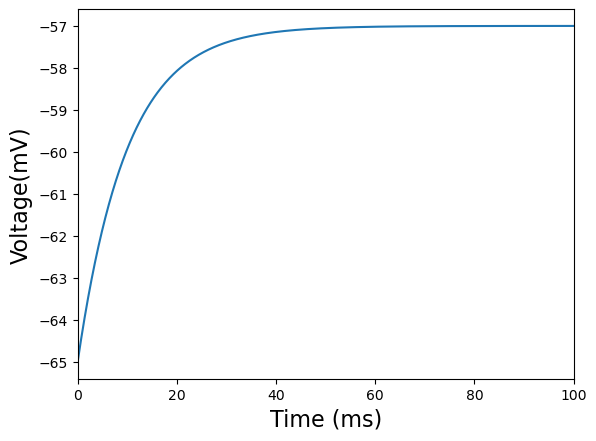

In [3]:
parameters = InitializeParameters()
parameters['Current'] = 180
Voltage = LeakyIntegrate(parameters,'constant')[0]
Spikes = LeakyIntegrate(parameters,'constant')[1]

plt.xlim(0,100)
plt.xlabel('Time (ms)',fontsize = 16)
plt.ylabel('Voltage(mV)',fontsize = 16)
plt.plot(parameters['Timegrid'],Voltage)
plt.savefig('LIFConst180.svg')

plt.show()

The output voltage plateaus to a certain value below the threshold. This is the farthest it can go. This is essentially because the voltage depends on the charge accumulated on the membrane. If there isn't sufficient charge in the current, the neuron will never spike.

## Running the Leaky Integrate and Fire Model with a sinusoidal Input current:

We now turn towards some more exotic currents. Lets try applying a sinusoidal input current. We only need to modify the current in our LeakyIntegrate function:

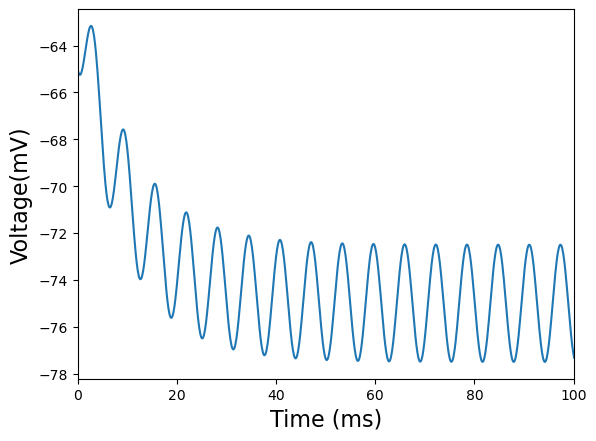

In [4]:
parameters = InitializeParameters()
parameters['Current'] = 250
Voltage = LeakyIntegrate(parameters,'sine')[0]
Spikes = LeakyIntegrate(parameters,'sine')[1]

plt.xlim(0,100)
plt.xlabel('Time (ms)',fontsize = 16)
plt.ylabel('Voltage(mV)',fontsize = 16)
plt.plot(parameters['Timegrid'],Voltage)
plt.savefig('LIFSine250_1.svg')
plt.show()

As it stands, this response to the current is quite un-interesting. Why? For one, the output voltage never reaches its threshold value, which means there is no spiking. In fact, we can numerically show this by printing out our spike array, which we just extracted after running our LIF for the sinusoidal input:

In [5]:
print(Spikes)

[]


Alas! It is empty. But why is this so? Well, one could argue that as it stands, the sinusoidal current has too big of a frequency for the voltage output to be integrated appreciably enough such that it reaches the threshold voltage. What happens instead is that the output becomes a sine wave whose mean value decays until it reaches some static value. This is because we started the current at an initial value of -65.

To test our hypothesis that the output is indeed not spiking because of the large frequency we now run the LIF model again, only this time with a prefactor of 0.02 next to the argument of the sine function (this serves to decrease the frequency, giving the output enough time to be integrated so as to reach the threshold frequency). And indeed that is what happens:

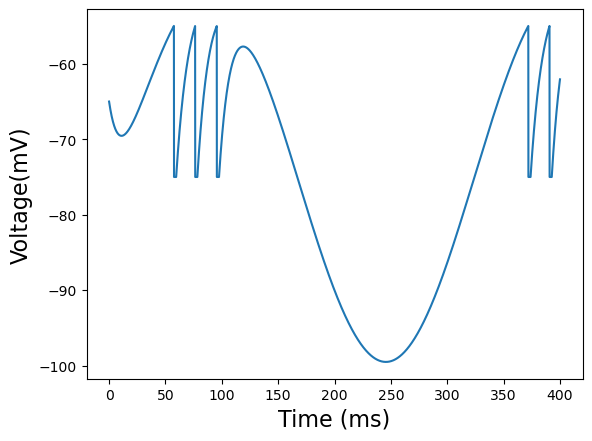

[ 57.5  76.3  95.5 371.8 390.6]


In [6]:
parameters = InitializeParameters()
Voltage = LeakyIntegrate(parameters,'sine',0.02)[0]
Spikes = LeakyIntegrate(parameters,'sine',0.02)[1]


plt.xlabel('Time (ms)',fontsize = 16)
plt.ylabel('Voltage(mV)',fontsize = 16)
plt.plot(parameters['Timegrid'],Voltage)
plt.savefig('LIFSine250_0.02.svg')

plt.show()
print(Spikes)

Indeed during the increasing part of the input current there is now spiking (as can also be seen from the printed Spike array). Our hypothesis was correct! We can also argue that for a given frequency, one might increase the amplitude of the input current to observe spiking. Lets increase the current to 2500 to see if that happens:

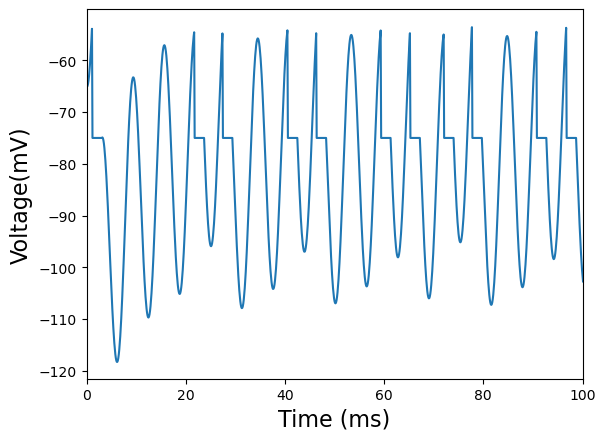

[  1.1  21.7  27.4  40.5  46.3  59.3  65.2  72.   77.7  90.7  96.7 103.3
 109.2 116.  121.6 134.7 140.6 147.4 153.1 166.1 172.1 178.7 184.6 191.4
 197.  210.1 216.  222.8 228.5 241.5 247.5 254.1 260.  266.8 272.4 285.5
 291.4 298.2 303.9 316.9 322.9 329.5 335.4 342.2 347.8 360.9 366.8 373.6
 379.3 392.3 398.3]


In [7]:
parameters = InitializeParameters()
parameters['Current'] = 2500

Voltage = LeakyIntegrate(parameters,'sine')[0]
Spikes = LeakyIntegrate(parameters,'sine')[1]

plt.xlim(0,100)
plt.xlabel('Time (ms)',fontsize = 16)
plt.ylabel('Voltage(mV)',fontsize = 16)
plt.plot(parameters['Timegrid'],Voltage)
plt.savefig('LIFSine2500_1.svg')
plt.show()

print(Spikes)

And that is indeed what we see! If you don't give the signal enough time to integrate upto the threshold voltage, you have to give it more amplitude to get there in that shorter span of time.

## Running the Leaky Integrate and Fire Model with a Guassian White Noise Input Current:

Using Gaussian White Noise as input for a model gives us valuable insight into how the neuron working under such a model would behave in actual physical situations. This is because the neuron is always receiving noisy input signals from its environment. To generate a Gaussian White Noise input current, we do what we have been doing before: we change our function so as to allow for a currenttype parameter value of "GWN".

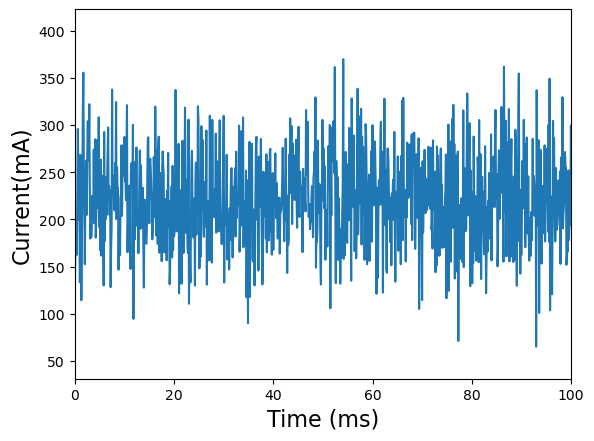

[ 16.6  43.8  67.4  91.2 118.7 146.1 170.1 197.4 224.8 246.4 271.2 297.2
 321.3 345.8 372.5 399.3]


In [8]:
parameters = InitializeParameters()
parameters['Current'] = 220

Voltage = LeakyIntegrate(parameters,'GWN',sig = 0.5)[0]
Spikes = LeakyIntegrate(parameters,'GWN',sig = 0.5)[1]
Current = LeakyIntegrate(parameters,'GWN',sig = 0.5)[2]

plt.xlim(0,100)
plt.xlabel('Time (ms)',fontsize = 16)
plt.ylabel('Current(mA)',fontsize = 16)
plt.plot(parameters['Timegrid'],Current)
plt.savefig('GWNCurrent.svg')
plt.show()
print(Spikes)

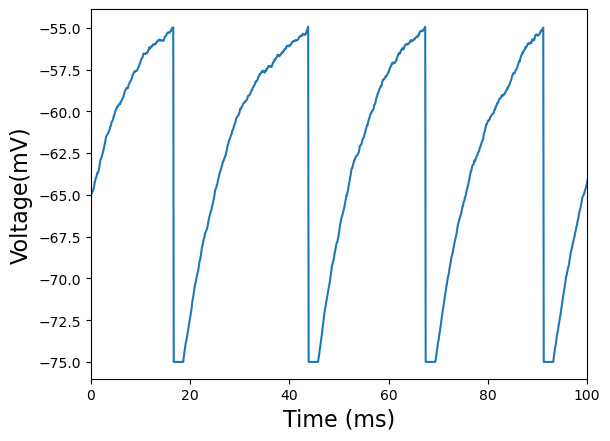

In [9]:
plt.xlim(0,100)
plt.xlabel('Time (ms)',fontsize = 16)
plt.ylabel('Voltage(mV)',fontsize = 16)
plt.plot(parameters['Timegrid'],Voltage)
plt.savefig('GWNVoltage.svg')
plt.show()

## Maximum and Minimum Spiking Frequencies:

After tweaking the value of the input current for some time it was found that the smallest current that generates spikes is actually 200 units. Any constant current with less amplitude than this does not generate spikes. We perturb the current to a value only slightly higher than this and then use the numpy ediff1d function to calculate the time duration between successive spikes in our Spikes array. This comes out to be the same for all of the interspike durations:

[306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9
 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9
 306.9 306.9 306.9 306.9 306.9 306.9 306.9]


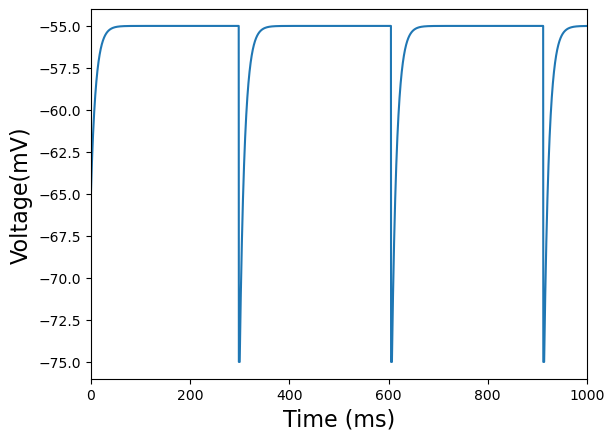

In [10]:
parameters = InitializeParameters()
parameters['Current'] = 200.00000000001
parameters['Duration'] = 10000.
parameters['Timestep'] = 0.1
parameters['Timegrid'] = np.arange(0, parameters['Duration'], parameters['Timestep'])

Voltage = LeakyIntegrate(parameters,'constant')[0]
Spikes = LeakyIntegrate(parameters,'constant')[1]


SpikeDistances = np.ediff1d(Spikes)
print(SpikeDistances)

plt.xlim(0,1000)
plt.xlabel('Time (ms)',fontsize = 16)
plt.ylabel('Voltage(mV)',fontsize = 16)
plt.plot(parameters['Timegrid'],Voltage) 
plt.savefig('MinFreq.svg')
plt.show()

MinSpikingFrequency = 1/np.mean(SpikeDistances)

We can then increase the current to an arbitrarily high value to calculate the maximum spiking frequency as follows:

[2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1
 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1
 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1]


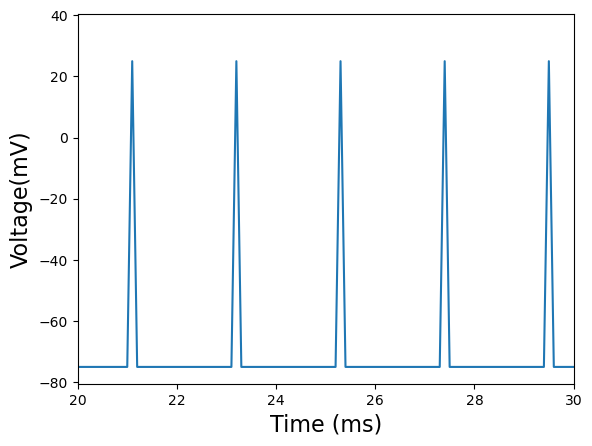

In [11]:
parameters = InitializeParameters()
parameters['Current'] = 100000
parameters['Duration'] = 100.
parameters['Timestep'] = 0.1
parameters['Timegrid'] = np.arange(0, parameters['Duration'], parameters['Timestep'])

Voltage = LeakyIntegrate(parameters,'constant')[0]
Spikes = LeakyIntegrate(parameters,'constant')[1]

plt.xlim(20,30)
plt.xlabel('Time (ms)',fontsize = 16)
plt.ylabel('Voltage(mV)',fontsize = 16)
plt.plot(parameters['Timegrid'],Voltage)
plt.savefig('MaxFreq.svg')
SpikeDistances = np.ediff1d(Spikes)
print(SpikeDistances)
plt.show()

MaxSpikingFrequency = 1/np.mean(SpikeDistances)
print()

The interspike distances clearly plateau at a value of about 2.1. Any increase in the input current beyond this point has no effect on the output voltage signal. This is because the refractory period prevents the neuron from spiking at arbitrarily high frequencies.

In [12]:
print("The maximum spiking frequency is: " + str(MaxSpikingFrequency) + " per millisecond")
print("The minimum spiking frequency is: " + str(MinSpikingFrequency) + " per millisecond")

The maximum spiking frequency is: 0.47619047619047616 per millisecond
The minimum spiking frequency is: 0.003258390355164549 per millisecond


## Plotting Spiking Frequency against Input Current:

We now run the model for different constant values of the input current and see how the spiking frequency varies.

<function matplotlib.pyplot.show(close=None, block=None)>

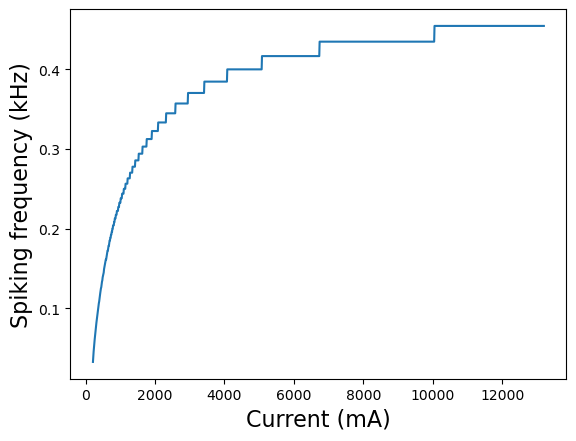

In [13]:
step = 10
Currents = np.zeros(1300)
Frequencies = np.zeros(1300)
parameters['Duration'] = 10
parameters['Current'] = 202

for i in range(1300): 
    parameters['Current'] += step
    Voltage = LeakyIntegrate(parameters,'constant')[0]
    Spikes = LeakyIntegrate(parameters,'constant')[1]
    SpikeDistances = np.ediff1d(Spikes)
    SpikingFrequency = 1/SpikeDistances[0]
    Frequencies[i] = SpikingFrequency
    Currents[i] = parameters['Current']
    
plt.xlabel('Current (mA)',fontsize = 16)
plt.ylabel('Spiking frequency (kHz)',fontsize = 16)
plt.plot(Currents,Frequencies)
plt.savefig('FI.svg')
plt.show

Notice how the spiking frequency increases as we increase the input current until a plateau is reached. This plateau indicates the point where a further increase in current has no effect on the spiking frequency since the refractory period prevents any more spikes from being produced.

## Effect of standard deviation of GWN current on the spiking frequency:

We now apply gaussian white noise currents with different standard deviations to our LIF model and notice how the FI curve is affected:

C:\Users\Malaik Kabir\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Malaik Kabir\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


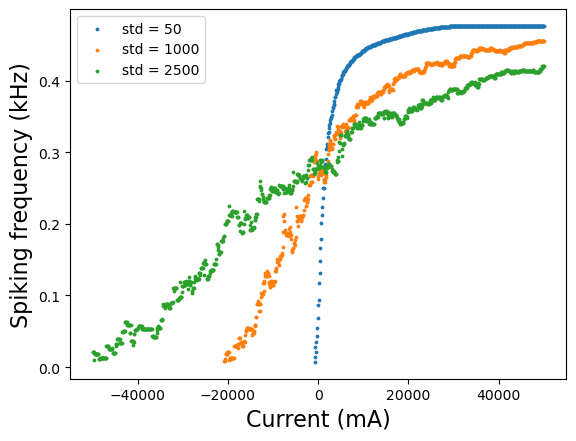

In [216]:
deviations = np.array([50,1000,2500])
import scipy as sc

for j in range(3):
    step = 100
    Currents = np.zeros(1000)
    Frequencies = np.zeros(1000)
    parameters['Duration'] = 10
    parameters['Current'] = -50000

    for i in range(1000):
        parameters['Current'] += step
        Spikes = LeakyIntegrate(parameters,'GWN',sig = deviations[j])[1]
        SpikeDistances = np.ediff1d(Spikes)
        SpikingFrequency = 1/np.mean(SpikeDistances)
        Frequencies[i] = SpikingFrequency
        Currents[i] = parameters['Current']
        
    plt.xlabel('Current (mA)',fontsize = 16)
    plt.ylabel('Spiking frequency (kHz)',fontsize = 16)
    plt.scatter(Currents,Frequencies, label = 'std = ' + str(deviations[j]),s=3)
    plt.legend()
    plt.savefig('FI2.svg')


plt.show()



Evidently, increasing the standard deviation has the effect that the spiking frequency gets saturated at higher values of the mean current. We also note that as the standard deviation is increased, the non-linearity in the standard deviation against the current starts to get smoothened out until the function almost resembles a straight line.

## Relation between spiking frequency and the coefficient of variation of the GWN current:

The formula for the coefficient of variation ($CV_{ISI}$) is:

$$CV_{ISI} = \frac{\text{std}(isi)}{\text{mean}(isi)}$$

### Standard Deviation:

It is evident that increasing the standard deviation of the current increses the coefficient of variation of the interspike intervals. This is precisely because a greater standard deviation for a given mean basically just means that the fluctuations in the current around that mean value are stronger. Since these fluctuations are guassian-random, this means that there are just as many large deviations below the mean as there are above the mean. Consequently, for larger standard deviations, as the LIF is trying to integrate a large positive signal, a large negative incursion immediately afterwards might counter-act it, resulting in less spiking frequency for that particular mean value.

### Mean:

The greater the mean the higher the lower the coefficient of variation in the interspike distances. This is actually quite easy to understand. Since the current fluctuates around the mean, if the mean is higher the output voltage in general fluctuates closer to the threshold voltage. This in turn means that the number/frequency of spikes is larger.

## 2) The Hodgkin-Huxley Model:

The Hodgkin-Huxley model is a relatively computationally expensive model which was developed by Hodgkin Huxley following their experiments on the giant axon of a squid. One of the great advantages of the model is that the spiking behaviour is built into the differential equations, there is nothing that needs to be introduced in an ad-hoc manner. The disadvantage that comes with this is that a number of different variables (known as the gating variables) need to be kept track of, each of which is governed by its own differential equations.

The Hodgkin Huxley model is similar to the LIF model in that there is a leak resistance. In all other aspects, however, it is radically different. For one, the HH model treats the currents due to each of the individual ion channels in the neuronal membrane separately. The equation that governs the HH model is:

$$I(t) = I_{C}(t) + \sum_k I_k (t)$$

Here $I(t)$ is the total current across the membrane of the neuron. $I_C(t)$ on the other hand is the current that goes into charging the capacitive part of the model. The sum over currents is simply the sum over the currents due to all of the ions (the ion indices are what the dummy variable $k$ runs over). While in the original Hodgkin-Huxley model only three currents (sodium, potassium and the leak current) were used in this sum, the great flexibility of the HH model lies in the fact that if new ions are discovered to play a role in action potential generation, they can simply be added into this sum to make the model more accurate. Now using:

$$I_C(t) = C\frac{dV}{dt}$$

We can re-arrange the equation and write it as:

$$C\frac{dV}{dt} =  -\sum_k I_k (t) + I(t)$$

The output voltage thus obeys this equation. While this might seem like a simple enough equation, there is a lot going on at the back. For one if we expand the sum and use ohm's law (replacing $\frac{1}{R}$ by $g$, the conductance) we get the following equations:

$$\begin{align}I_{Na} &= g_{Na}m^{3}h(V-E_{Na}) \\\\ I_{K} &= g_{K}n^{4}(V-E_{K}) \\\\ I_{L} &= g_{L}(V-E_{L})\end{align}$$

While the equation for the leak current is exactly how one would expect, the equations for the two ions differ from our expectations due to the presence of the variables $m$, $n$ and $h$. These are exactly the gating variables that were mentioned previously. Hodgkin and Huxley discovered these dependences from the form of the output signal. These were more or less fitting parameters to them. However, these have a biological basis. The powers on these parameters are governed by the number of subunits on a channel admitting a particular ion.

## Gating variables:

The gating variables are governed by the following equations:

$$\dot m = \alpha_m(V)(1-m) - \beta_m (V)m$$

$$\dot n = \alpha_n(V)(1-n) - \beta_n (V)n$$

$$\dot h = \alpha_h(V)(1-h) - \beta_h (V)h$$

Where the $\alpha$ and $\beta$ terms can be thought of as rates of transition from closed to open and from open to closed states respectively.

In order to code up the model, however we must bring these equations into an even more suitable (and explicit) form. One that makes the qualitative features of the resulting curves more visible. Lets do this for the first equation. Distributing the coefficients we get:

$$\begin{align}\dot m &= \alpha_m- \alpha_m m- \beta_mm \\\\ \dot m &= \alpha_m- (\alpha_m - \beta_m)m\end{align}$$

If we now set the rate of change of m (i.e $\dot m$) equal to zero, we obtain the steady state of the equation. This gives us information about the maximum value that m can reach:

$$\begin{align}0 &= \alpha_m- (\alpha_m - \beta_m)m_{max} \\\\  m_{max} &= \frac{\alpha_m}{(\alpha_m - \beta_m)}\end{align}$$

This is the maximum value that $m$ can reach. If we rewrite the original equation in terms of this $m_{max}$ now we obtain:

$$\begin{align}\frac{\dot m}{(\alpha_m - \beta_m)} &= \frac{\alpha_m}{(\alpha_m - \beta_m)}- m  \\\\
\dot m \tau_m &= m_{max}- m \\\\
\end{align}$$

Where we defined a time parameter:

$$\tau_m = \frac{1}{(\alpha_m - \beta_m)}$$

so that our final equation is:

$$\frac{dm}{dt}  = \frac{m_{max}- m}{\tau_m}$$

The other two equations can be rearranged similarly. This is the form of the equations that we will be solving for. In addition to this, it should be noted that by using a similar prescription, we can rewrite our original voltage equation in exactly the same form:

$$\frac{dV}{dt}  = \frac{V_{max}- V}{\tau_V}$$

Where we have defined:

$$V_{max} = \frac{g_{Na}V_{Na} + g_{K}V_{K} + g_{L}V_{L} + I_{injected}}{g_{Na} + g_{K} + g_{L}}$$

Where we have redefined $V_{max} - E_k = V_k$ with the subscript $k$ representing the ion index once again. In a similar manner we have defined:

$$\tau_{V} = \frac{C}{g_{Na} + g_{K} + g_{L}}$$

Note: the gating variables HAVE BEEN ABSORBED into $g_k$ (for all k) in this case. The reason why we did this is because now the differential equations dictating the evolution of all of the variables are of the form:

$$\dot x = \frac{x_{max}-x}{\tau}$$

And so have the same solution. This will be helpful in the code.

## Coding up the Hodgkin-Huxley Model:

In order to streamline the process of coding up and running the model, we once again store all of the parameters in one place:

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def InitializeParametersHodgkin():
    
    #The rest voltage
    parameters['Vrest'] = -64.9964
    
    #The rest value of the gating variable m
    parameters['mrest'] = 0.0530
    
    #The rest value of the gating variable n
    parameters['nrest'] = 0.3177
    
    #The rest value of the gating variable h
    parameters['hrest'] = 0.5960
    
    #The value of voltage next to the sodium conductance term (for the stationary state)
    parameters['VNa'] = 50
    
    #The value of voltage next to the potassium conductance term (for the stationary state)
    parameters['VK'] = -77
    
    #The value of voltage next to the leak conductance term (for the stationary state)
    parameters['VL'] = -54.387
    
    #The maximum possible sodium channel conductance
    parameters['gNamax'] = 1.2
    
    #The maximum possible potassium channel conductance
    parameters['gKmax'] = 0.36
    
    #The leak conductance
    parameters['gL'] = 0.003
    
    #The capcitance of the membrane
    parameters['C'] = 0.010
    
    #Time step dt between the intervals
    parameters['Timestep'] = 0.1
    
    #The number of iterations for which the model is going to run
    parameters['Duration'] = 1000
    
    #All of the time values stored in a numpy array
    parameters['Timegrid'] = np.arange(0, parameters['Duration'], parameters['Timestep'])
    
    #Constant current applied
    parameters['Current'] = 0.01
    
    return parameters

## Running the Hodgkin-Huxley model with a constant input Current:

In [199]:
def HodgkinHuxley(parameters, currenttype = 'constant', freq = 1 , sig = 1):
    
    #The rest values of the parameters: 
    
    Vrest = parameters['Vrest']
    mrest = parameters['mrest']
    nrest = parameters['nrest']
    hrest = parameters['hrest']
    
    #(V-E_k) values for calculating V_max (basically V_infinity):
    
    VNa = parameters['VNa']
    VK = parameters['VK']
    VL = parameters['VL']
    
    #The maximal conductance values:
    
    gNamax = parameters['gNamax']
    gKmax = parameters['gKmax']
    gL = parameters['gL']
    
    #The conductance:
    
    C = parameters['C'] = 0.010
    
    #Variables controlling the running of the simulation:
    
    Timestep = parameters['Timestep']
    Timegrid = parameters['Timegrid']
    size = Timegrid.size
    
    I = parameters['Current']
    
    #Decides what type of current to run the model with:
    
    if currenttype == 'constant':
        Current = I*np.ones(size)
    
    elif currenttype == 'sine':
        Current = I*np.sin(freq*Timegrid)
        
    elif currenttype == 'GWN':
        np.random.seed()
        Current = sig*np.random.randn(size)/np.sqrt(Timestep/1000.) + I
        
    elif currenttype == 'postinhibitory':
        Current = I*np.zeros(size)
        for i in range(3333,6666):
            Current[i] = -0.5
        
    #Here are the empty vectors that we will be filling with our values:
    
    Vout   = np.zeros(size)
    mout   = np.zeros(size)   
    hout   = np.zeros(size)
    nout   = np.zeros(size)
    spikeout = []
    
    #We initialize the variables we will be changing using the rest values:
    
    V = Vrest
    m = mrest
    n = nrest
    h = hrest
    
    #The amount of time that needs to elapse before counting a new spike
    
    wait = 30

    for i in range(size):
        
        #We first update the values of our conductances (taking into account the gating variables)
        
        gNa = gNamax*(m**3)*h
        gK  = gKmax*(n**4)
        
        #Then calculate the values of Vmax and the time constant TauV 
        
        gTotal = gK + gNa + gL
        
        Vmax = (gNa*VNa + gK*VK + gL*VL + Current[i])/gTotal
        TauV = C/gTotal
        
        #We then update the value of the voltage using the solution to the differential equation
        
        V = Vmax + (V-Vmax)*np.exp(-Timestep/TauV)
        
        #Using the provided expressions for the transition rates:
        
        alpham = 0.1*(V+40)/(1-np.exp(-(V+40)/10)) 
        betam = 4*np.exp(-0.0556*(V+65))
        
        alphan = 0.01*(V+55)/(1-np.exp(-(V+55)/10))
        betan = 0.125*np.exp(-(V+65)/80)
        
        alphah = 0.07*np.exp(-0.05*(V+65))
        betah = 1/(1+np.exp(-0.1*(V+35)))
        
        #We then calculate Taus for the three parameters
        
        Taum  = 1/(alpham + betam)
        Taun  = 1/(alphan + betan)
        Tauh  = 1/(alphah + betah)    
        
        #And then the max (or inf) values of the parameters
        
        mmax = alpham*Taum
        nmax = alphan*Taun
        hmax = alphah*Tauh
        
        #And then we use the solutions to the differential equations to update the values of the parameters
        
        m = mmax + (m-mmax)*np.exp(-Timestep/Taum)
        n = nmax + (n-nmax)*np.exp(-Timestep/Taun)
        h = hmax + (h-hmax)*np.exp(-Timestep/Tauh)
        
        #Spikes are recorded using this if statement
        
        if (wait == 0) & (V >= 0):
            spikeout.append(Timegrid[i])
            wait = 50
            
        elif wait > 0:
            wait = wait -1
        
        #And finally we update the vectors
        
        Vout[i]   = V
        mout[i]   = m  
        hout[i]   = h
        nout[i]   = n
    
    spikeout = np.array(spikeout)
    
    return Vout,mout,hout,nout,spikeout

In order to count spikes we first decide on a threshold voltage of 0mV such that whenever the output signal exceeds that value we count it as a spike.

## Constant current of 0.01 microAmps per mm squared:

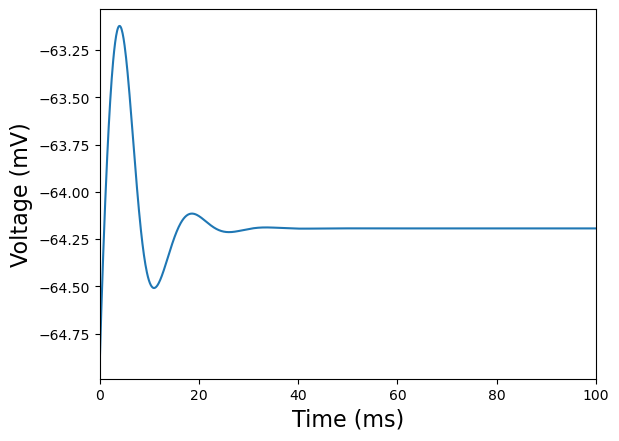

[]


In [60]:
parameters = InitializeParametersHodgkin()
V,m,h,n,s = HodgkinHuxley(parameters, currenttype = 'constant')
t = parameters['Timegrid']

plt.xlim(0,100)
plt.ylabel('Voltage (mV)',fontsize = 16)
plt.xlabel('Time (ms)',fontsize = 16)
plt.plot(t,V)
plt.savefig('HH0.01.svg')
plt.show()
print(s)

The above is a plot of the response of the Hodgkin Huxley model to a constant current input of about 0.01 units. What is observed is not a spike (the highest value that the voltage reaches is a little over -63.25). The initial kick in the voltage comes from the starting values of the voltage and the gating variables. The current clearly is not enough to generate a spike.

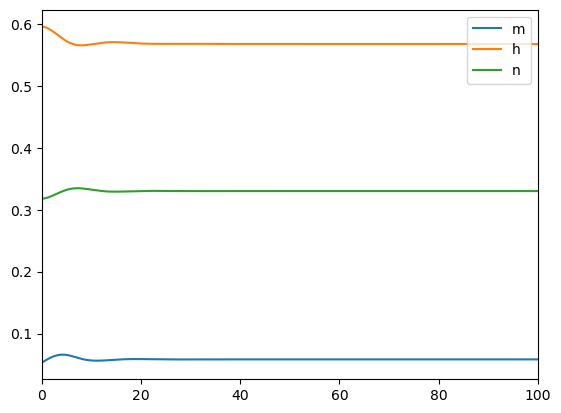

In [40]:
plt.plot(t,m,label = 'm')
plt.plot(t,h,label = 'h')
plt.plot(t,n,label = 'n')
plt.xlim(0,100)
plt.legend()

## Constant current of 0.05 microAmps per mm squared:

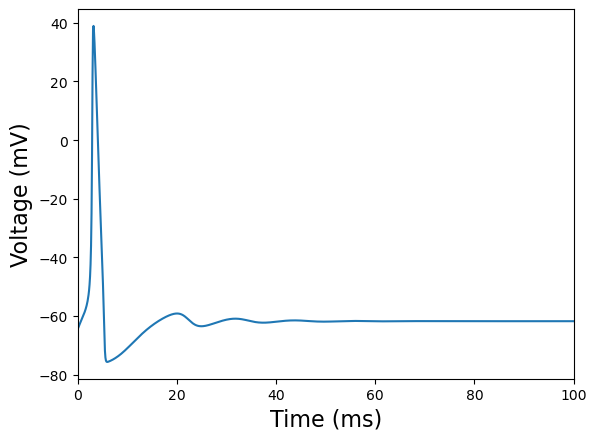

[3.]


In [61]:
parameters = InitializeParametersHodgkin()
t = parameters['Timegrid']
parameters['Current'] = 0.05
V,m,h,n,s = HodgkinHuxley(parameters, currenttype = 'constant')

plt.xlim(0,100)
plt.ylabel('Voltage (mV)',fontsize = 16)
plt.xlabel('Time (ms)',fontsize = 16)
plt.plot(t,V)
plt.savefig('HH0.05.svg')
plt.show()

print(s)

At 0.05 microamperes per millimeters squared, a single spike is observed. This is again because the voltage as well as the gating variables are given some initial value. However, after the spike the constant value of the current is not sufficient to generate subsequent spikes, resulting in a constant voltage.

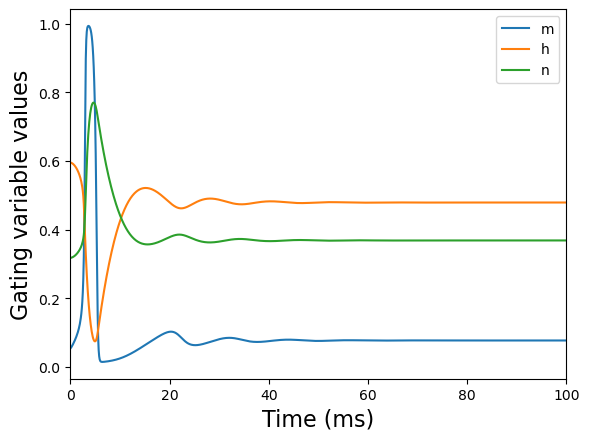

In [42]:
plt.xlim(0,100)
plt.ylabel('Gating variable values',fontsize = 16)
plt.xlabel('Time (ms)',fontsize = 16)
plt.plot(t,m,label = 'm')
plt.plot(t,h,label = 'h')
plt.plot(t,n,label = 'n')
plt.legend()
plt.savefig('HH0.05gating.svg')
plt.legend()

## Constant current of 0.1 microAmps per mm squared:

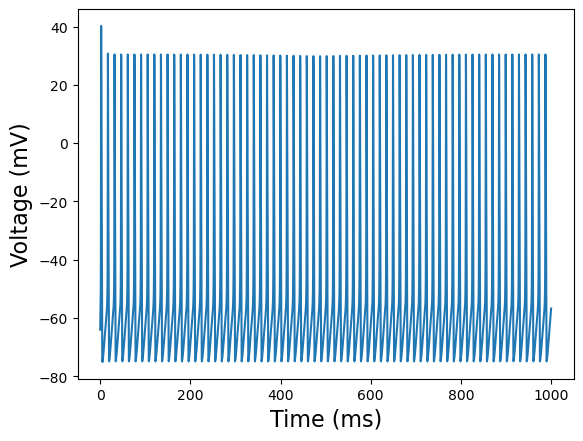

68


In [178]:
parameters = InitializeParametersHodgkin()
parameters['Current'] = 0.1
t = parameters['Timegrid']
V,m,h,n,s = HodgkinHuxley(parameters, currenttype = 'constant')

plt.ylabel('Voltage (mV)',fontsize = 16)
plt.xlabel('Time (ms)',fontsize = 16)
plt.plot(t,V)
plt.savefig('HH0.1.svg')
plt.show()

print(s.size)

At a constant current of 0.1 microamperes per millimeters squared, a spike train is observed. This can be attributed to the fact that the value of the sustained current is above the threshold value so that everytime the voltage returns to its baseline value  there is enough current to generate a spike again.

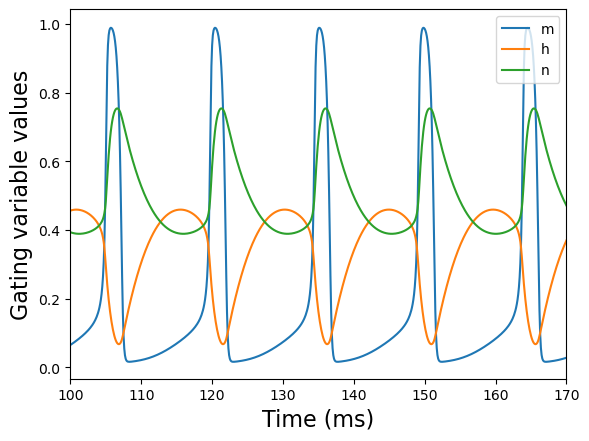

In [44]:
plt.xlim(100,170)
plt.ylabel('Gating variable values',fontsize = 16)
plt.xlabel('Time (ms)',fontsize = 16)
plt.plot(t,m,label = 'm')
plt.plot(t,h,label = 'h')
plt.plot(t,n,label = 'n')
plt.legend()
plt.savefig('HH0.1gating.svg')



## Constant current of 5 microAmps per mm squared:

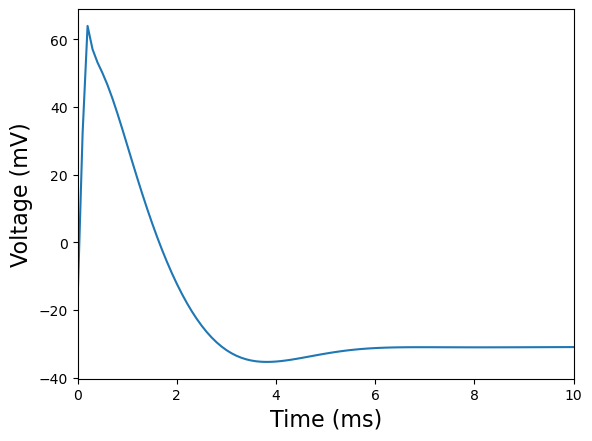

In [45]:
parameters = InitializeParametersHodgkin()
t = parameters['Timegrid']
parameters['Current'] = 5
V = HodgkinHuxley(parameters, currenttype = 'constant')[0]
m = HodgkinHuxley(parameters, currenttype = 'constant')[1]
h = HodgkinHuxley(parameters, currenttype = 'constant')[2]
n = HodgkinHuxley(parameters, currenttype = 'constant')[3]


plt.xlim(0,10)
plt.ylabel('Voltage (mV)',fontsize = 16)
plt.xlabel('Time (ms)',fontsize = 16)
plt.plot(t,V)
plt.savefig('HH5.svg')
plt.show()

At 5 microamperes per millimeters squared, we only see one spike (which is a lot more spread out than the previous spikes and has a significantly greater amplitude). Plotting the gating variables against time gives us some insight into this behaviour. The peak for the gating variable m is a lot more spread out in time, as a result the spike is a lot more spread out. On the other hand the gating variable h goes to zero after a while, which means the sodium current is cut off completely. Oe can attribute this to the inactivation of the gates beyond a certain current.

<function matplotlib.pyplot.show(close=None, block=None)>

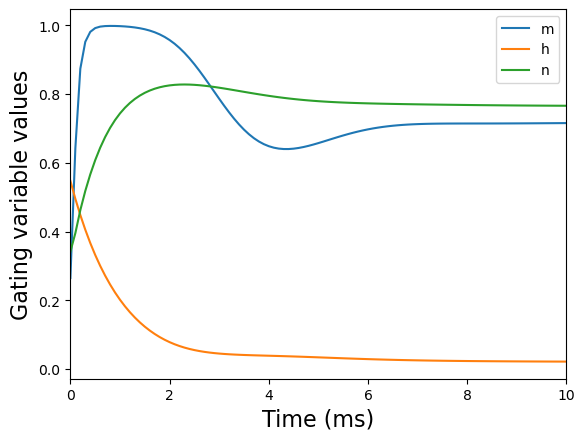

In [46]:
plt.xlim(0,10)
plt.ylabel('Gating variable values',fontsize = 16)
plt.xlabel('Time (ms)',fontsize = 16)
plt.plot(t,m,label = 'm')
plt.plot(t,h,label = 'h')
plt.plot(t,n,label = 'n')
plt.legend()
plt.savefig('HH5gating.svg')
plt.show

## Maximum and Minimum Spiking Frequencies:

We now tweak the value of the current for the Hodgkin Huxley model until we find the maximum and minimum spiking frequencies. Notice there is a caveat here. Since we decided on an arbitrary threshold value (0mV in our case), we will only treat excursions that reach this threshold value as spikes. We notice that as we increase the current while the frequency of spikes increases, the amplitude that the spikes reach actually **decreases**.

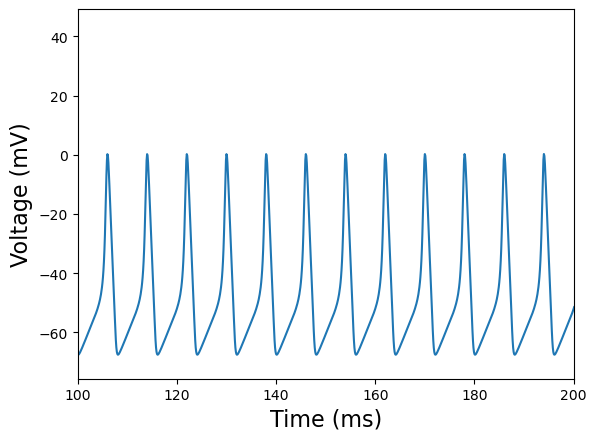

The minimum spiking frequency is : 0.125 kHz


In [139]:
parameters = InitializeParametersHodgkin()
t = parameters['Timegrid']
T = parameters['Duration']
parameters['Current'] = 0.62
V = HodgkinHuxley(parameters, currenttype = 'constant')[0]
s = HodgkinHuxley(parameters, currenttype = 'constant')[4]

plt.xlim(100,200)
plt.ylabel('Voltage (mV)',fontsize = 16)
plt.xlabel('Time (ms)',fontsize = 16)
plt.plot(t,V)
plt.savefig('HHmaxfreq.svg')
plt.show()

spike_number = s.size
print("The minimum spiking frequency is : " + str(spike_number/T) + " kHz")

We find that the maximum spiking frequency is observed for a current of about 0.62 microAmps/ millimeters squared. We now try to find the minimum spiking frequency by finding the lowest value of current for which a spike train is generated.

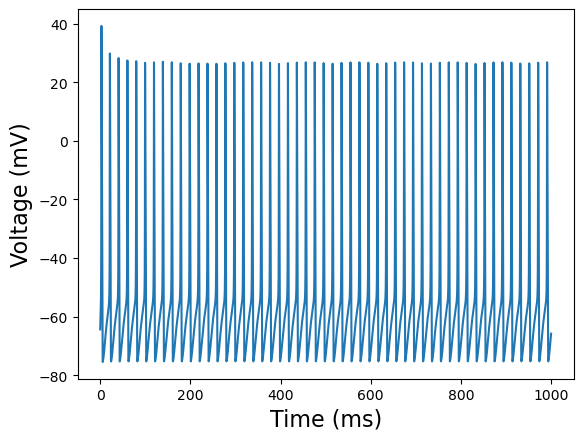

51
The minimum spiking frequency is : 0.051 kHz


In [204]:
parameters = InitializeParametersHodgkin()
parameters['Duration'] = 1000
T = parameters['Duration']
parameters['Current'] = 0.0626
parameters['Timegrid'] = np.arange(0, T, parameters['Timestep'])
t = parameters['Timegrid']
V = HodgkinHuxley(parameters, currenttype = 'constant')[0]
s = HodgkinHuxley(parameters, currenttype = 'constant')[4]


plt.ylabel('Voltage (mV)',fontsize = 16)
plt.xlabel('Time (ms)',fontsize = 16)
plt.plot(t,V)
plt.savefig('HHminfreq.svg')
plt.show()

spike_number = s.size
print(spike_number)
print("The minimum spiking frequency is : " + str(spike_number/T) + " kHz")

We find that the smallest value of current that can generate a spike train is about 0.0626 microAmps/ millimeters squared.

## Post-inhibitory rebound in HH:

We now use the post-inhibitory current type in our Hodgkin-Huxley simulator function. This stimulates the model with an input current that has a value of zero for about the first third of the duration for which the model runs, takes up a value of -5microAmps/mm squared for the second third of the duration, then steps back up to zero in the final third of the duration.

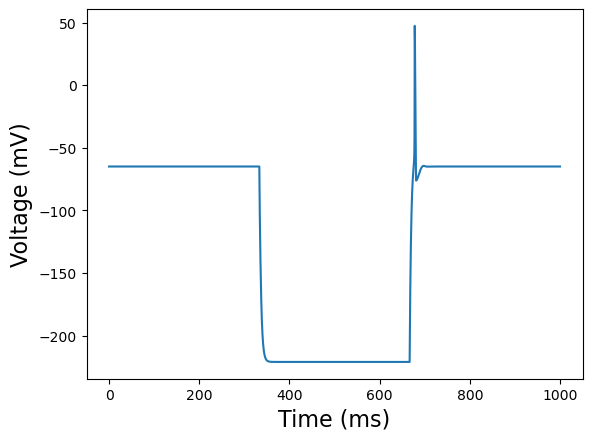

In [160]:
parameters = InitializeParametersHodgkin()
t = parameters['Timegrid']
T = parameters['Duration']
parameters['Current'] = 0.0626
V = HodgkinHuxley(parameters,currenttype = 'postinhibitory')[0]
s = HodgkinHuxley(parameters,currenttype = 'postinhibitory')[4]


plt.ylabel('Voltage (mV)',fontsize = 16)
plt.xlabel('Time (ms)',fontsize = 16)
plt.plot(t,V)
plt.savefig('HHpost.svg')

Notice how when the current is set to a negative value, the voltage dips to a lower baseline. Then, immediately after the current is brought back to its original value of zero, a spike is observed. The neuron fired, not as a result of stimulation, but rather as a result of being released from a prolonged state of **understimulation**. This is something that is observed in neurons experimentally and is a feature of the HH model (the LIF model cannot simulate this).

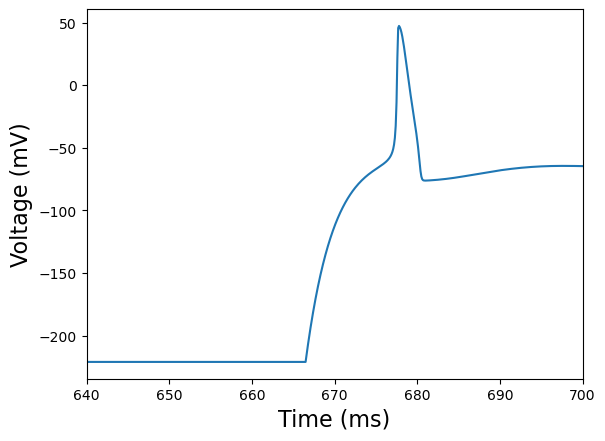

In [162]:
parameters = InitializeParametersHodgkin()
t = parameters['Timegrid']
T = parameters['Duration']
parameters['Current'] = 0.0626
V = HodgkinHuxley(parameters,currenttype = 'postinhibitory')[0]
s = HodgkinHuxley(parameters,currenttype = 'postinhibitory')[4]

plt.xlim(640,700)
plt.ylabel('Voltage (mV)',fontsize = 16)
plt.xlabel('Time (ms)',fontsize = 16)
plt.plot(t,V)
plt.savefig('HHpostzoomed.svg')

The above is a zoomed in version of the same plot, showing the spike generated after being released from inhibition.

## Plotting spiking frequency against input current:

<function matplotlib.pyplot.show(close=None, block=None)>

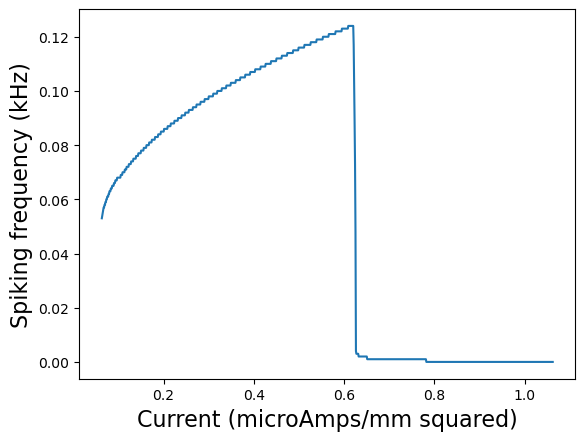

In [217]:
parameters = InitializeParametersHodgkin()
parameters['Duration'] = 1000
T = parameters['Duration']
parameters['Current'] = 0.062
parameters['Timegrid'] = np.arange(0, T, parameters['Timestep'])
t = parameters['Timegrid']
step = 0.001
Currents = np.zeros(1000)
Frequencies = np.zeros(1000)


for i in range(1000):
    parameters['Current'] += step
    Voltage,m,h,n,Spikes = HodgkinHuxley(parameters, currenttype = 'constant')
    spike_number = Spikes.size
    SpikingFrequency = spike_number/T
    Frequencies[i] = SpikingFrequency
    Currents[i] = parameters['Current']
    
plt.xlabel('Current (microAmps/mm squared)',fontsize = 16)
plt.ylabel('Spiking frequency (kHz)',fontsize = 16)
plt.plot(Currents,Frequencies)
plt.savefig('FI.svg')
plt.show

## Effect of standard deviation of GWN current on the spiking frequency:

<function matplotlib.pyplot.show(close=None, block=None)>

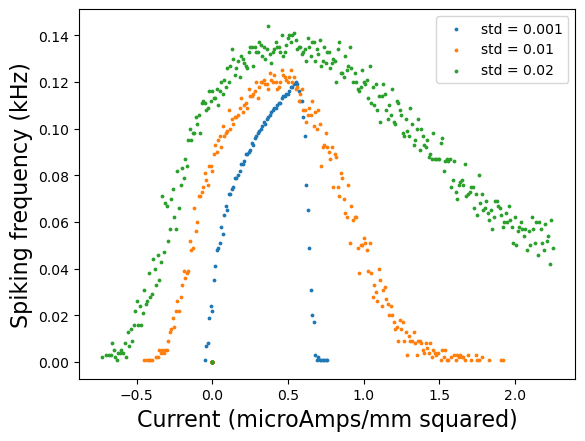

In [226]:
parameters = InitializeParametersHodgkin()
parameters['Duration'] = 1000
T = parameters['Duration']
parameters['Timegrid'] = np.arange(0, parameters['Duration'], parameters['Timestep'])
t = parameters['Timegrid']
step = 0.01
deviations = np.array([0.001,0.01,0.02])

for dev in deviations:
    
    parameters['Current'] = -0.75
    Currents = np.zeros(300)
    Frequencies = np.zeros(300)

    
    for i in range(300):
        parameters['Current'] += step
        Voltage,m,h,n,Spikes = HodgkinHuxley(parameters, currenttype = 'GWN',sig = dev)
        spike_number = Spikes.size
        
        if spike_number == 0:
            SpikingFrequency = 0
            
        else:
            SpikingFrequency = spike_number/T
            Frequencies[i] = SpikingFrequency
            Currents[i] = parameters['Current']
    
    plt.xlabel('Current (microAmps/mm squared)',fontsize = 16)
    plt.ylabel('Spiking frequency (kHz)',fontsize = 16)
    plt.scatter(Currents,Frequencies, label = 'std = ' + str(dev),s=3)
    plt.legend()
    plt.savefig('HHFI2.svg')

plt.show

 The following features are worth noting. For small values of standard deviation, the FI curve closely resembles the one we obtained for constant currents (which is to be expected). However, for larger values of the standard deviation, the FI curve starts at a smaller value of the current (this is, indeed, to be expected as well, since for a given mean current a larger standard deviation can cause the input current to attain a high enough value for a spike train to be generated). The peak frequency also increases for larger standard deviations. Finally we notice that for large values of the standard deviation, the frequency drops to zero at higher values of the current.